# DNA Embedding Analysis

This notebook explores the embedding quality of sequences from both pretrained and finetuned DNABERT models.

In [1]:
import bootstrap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import tf_utils as tfu
import wandb

In [3]:
strategy = tfu.strategy.gpu(0)

2022-06-10 19:31:01.189396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 19:31:01.189715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 19:31:01.195325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 19:31:01.195545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 19:31:01.195716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

## Weights & Biases

In [4]:
PROJECT = "deep-learning-dna"
MODEL_ARTIFACTS = {
    "pretrained-128dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:128dim",
    "pretrained-64dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:64dim",
    "pretrained-32dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:32dim",
    "pretrained-16dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:16dim",
    "pretrained-8dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:8dim",
    "pretrained-4dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:4dim",
    "pretrained-2dim": f"{PROJECT}/dnabert-pretrain-ablation-dim:2dim",
}

Here we get a public W&B API instance

In [5]:
api = wandb.Api()

Using the API instance, we can pull the dataset and model artifacts we wish to analyze.

In [6]:
dataset_path = api.artifact(f"{PROJECT}/dnasamples:latest").download()
dataset_path

wandb: Downloading large artifact dnasamples:latest, 186.27MB. 42 files... Done. 0:0:0


'./artifacts/dnasamples:v2'

In [7]:
model_artifact_paths = {}
for name, artifact in MODEL_ARTIFACTS.items():
    model_artifact_paths[name] = api.artifact(artifact).download()

## DNABERT Models

In [8]:
from common.models.dnabert import DnaBertPretrainModel, DnaBertAutoencoderModel, DnaBertEncoderModel

Load the models from the artifacts.

In [9]:
models = {}
with strategy.scope():
    for name, path in model_artifact_paths.items():
        basename = os.path.basename(path)
        if "dnabert-pretrain" in basename:
            models[name] = DnaBertEncoderModel(DnaBertPretrainModel.load(path).base)
        elif "dnabert-finetune" in basename:
            models[name] = DnaBertAutoencoderModel.load(path).encoder

Since there will be some configuration info we'll need to extract from the models, we will store a
reference to the base DNABERT model for quick access.

In [10]:
dnabert_base = list(models.values())[0].base

## DNA Samples

In [11]:
from common.data import find_dbs, DnaSequenceGenerator

We first locate the samples that we wish to analyze. Here we specify to use the testing samples
which were not seen during training.

In [12]:
SAMPLE_PATH = os.path.join(dataset_path, "test")

In [13]:
sample_files = find_dbs(SAMPLE_PATH)
sample_files

['fall_2016-10-07.db',
 'fall_2017-10-13.db',
 'spring_2016-04-22.db',
 'spring_2017-05-02.db',
 'spring_2018-04-23.db',
 'spring_2019-05-14.db',
 'spring_2020-05-11.db']

### Subsamples

In [14]:
NUM_SUBSAMPLES_PER_SAMPLE = 10
SUBSAMPLE_SIZE = 1000
SEQUENCE_LENGTH = dnabert_base.length
KMER = dnabert_base.kmer

In [15]:
rng = np.random.default_rng()

In [16]:
with strategy.scope():
    embedded_subsamples = {name: {} for name in models}
    for sample_file in sample_files:
        # Remove the prefix path from the sample file
        path = os.path.join(SAMPLE_PATH, sample_file)

        # For now, use a DNA kmer-sequence generator to generate subsamples.
        generator = DnaSequenceGenerator([path], SEQUENCE_LENGTH, KMER, SUBSAMPLE_SIZE,
                                            NUM_SUBSAMPLES_PER_SAMPLE, rng=rng)

        # Generate the embedded subsamples
        for name, model in models.items():
            embedded_subsamples[name][sample_file] = [model(subsample) for subsample in generator]

2022-05-23 15:20:34.846623: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## General Statistics

In [17]:
SAMPLE_FILE = sample_files[0]
SUBSAMPLE_INDEX = 0

In [18]:
# encoded_subsamples = {}
# for name, model in models.items():
#     encoded_subsamples[name] = model()
# pretrained_subsample = pretrained_samples[sample_files[SAMPLE_INDEX]][SUBSAMPLE_INDEX]
# finetuned_subsample = finetuned_samples[sample_files[SAMPLE_INDEX]][SUBSAMPLE_INDEX]

In [19]:
for model_name, subsamples in embedded_subsamples.items():
    print(f"{model_name} subsample min: {np.min(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample min: -11.365455627441406
pretrained-64dim subsample min: -9.564144134521484
pretrained-32dim subsample min: -10.467828750610352
pretrained-16dim subsample min: -12.483094215393066
pretrained-8dim subsample min: -18.848466873168945
pretrained-4dim subsample min: -15.563056945800781
pretrained-2dim subsample min: 5.362502098083496


In [20]:
for model_name, subsamples in embedded_subsamples.items():
    print(f"{model_name} subsample max: {np.max(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample max: 12.136026382446289
pretrained-64dim subsample max: 10.213887214660645
pretrained-32dim subsample max: 10.61893081665039
pretrained-16dim subsample max: 11.98466968536377
pretrained-8dim subsample max: 13.920464515686035
pretrained-4dim subsample max: 18.04347038269043
pretrained-2dim subsample max: 8.708880424499512


In [21]:
for model_name, subsamples in embedded_subsamples.items():
    print(f"{model_name} subsample mean: {np.mean(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample mean: 0.14351925253868103
pretrained-64dim subsample mean: 0.2233651876449585
pretrained-32dim subsample mean: 0.170848086476326
pretrained-16dim subsample mean: -0.09583926200866699
pretrained-8dim subsample mean: -0.8192867636680603
pretrained-4dim subsample mean: 1.3537750244140625
pretrained-2dim subsample mean: 7.725579261779785


In [22]:
for model_name, subsamples in embedded_subsamples.items():
    print(f"{model_name} subsample STD: {np.std(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX])}")

pretrained-128dim subsample STD: 3.2477877140045166
pretrained-64dim subsample STD: 2.8639702796936035
pretrained-32dim subsample STD: 3.118738889694214
pretrained-16dim subsample STD: 3.886035680770874
pretrained-8dim subsample STD: 6.5402607917785645
pretrained-4dim subsample STD: 7.1773247718811035
pretrained-2dim subsample STD: 0.9008802175521851


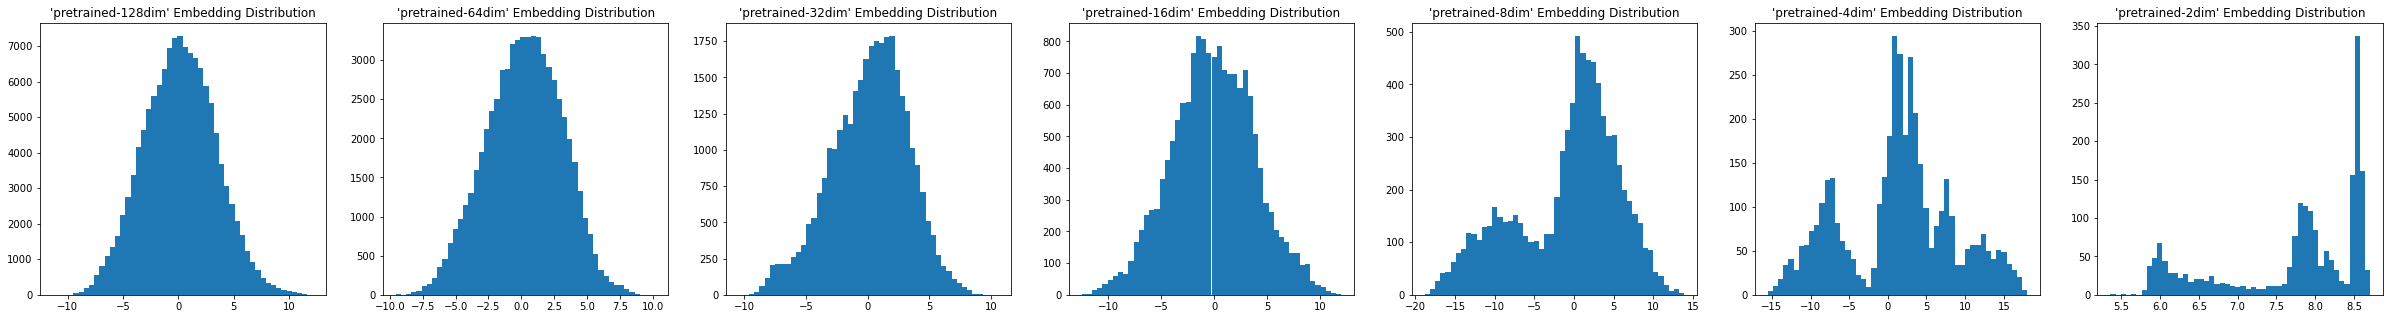

In [23]:
plt.figure(figsize=(6*len(models), 5))
for i, (model_name, subsamples) in enumerate(embedded_subsamples.items()):
    plt.subplot(1, len(models), i+1)
    plt.hist(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX].numpy().flatten(), bins=50)
    plt.title(f"'{model_name}' Embedding Distribution")
plt.show()

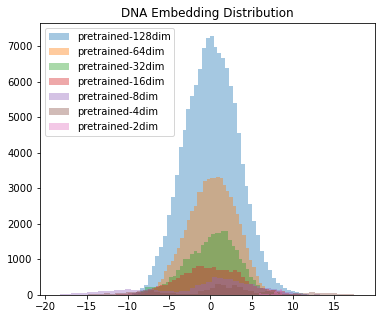

In [24]:
plt.figure(figsize=(6, 5))
for model_name, subsamples in embedded_subsamples.items():
    plt.hist(subsamples[SAMPLE_FILE][SUBSAMPLE_INDEX].numpy().flatten(), bins=50, alpha=0.4)
plt.legend(list(models.keys()))
plt.title("DNA Embedding Distribution")
plt.show()

## MDS

In [25]:
WORKERS = 24
SEED = 0

In [26]:
from scipy.spatial import KDTree
from common.metrics import chamfer_distance_matrix, mds, mds_stress_analysis

In order to increase the performance of Chamfer distance, the samples can be converted to KD-trees,
allowing us to compute the chamfer distance in ~O(nlogn) rather than O(n^2). The following cell
creates a concatenated list of KD-trees for each model-subsample group.

In [27]:
sample_trees = {name: [] for name in models}
for model_name, subsamples in embedded_subsamples.items():
    for sample_name in subsamples:
        sample_trees[model_name] += [KDTree(sample) for sample in subsamples[sample_name]]

Using the KD-trees, this next cell computes the chamfer distance matrices for each model group.

In [28]:
dist_mats = {}
for model_name, trees in sample_trees.items():
    dist_mats[model_name] = chamfer_distance_matrix(trees, workers=WORKERS)

With the distance matrices, the following cell computes the MDS for each distance matrix.

In [29]:
mds_pcas = {}
for model_name, dist_matrix in dist_mats.items():
    pca, _ = mds(dist_matrix, seed=SEED)
    mds_pcas[model_name] = pca.reshape((-1, NUM_SUBSAMPLES_PER_SAMPLE, 2))

Finally we can create a 2D plot of the resulting MDS groups to get an idea of DNA subsample
similarities.

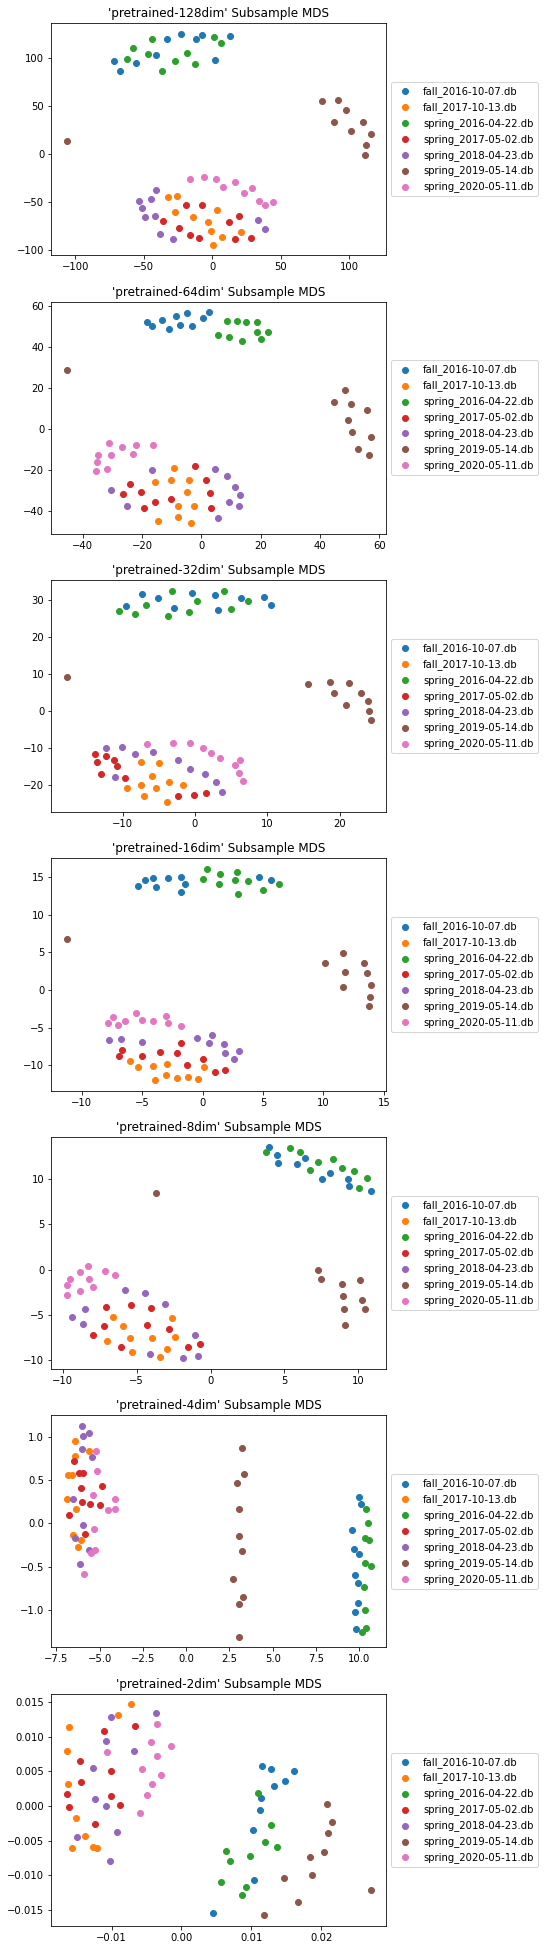

In [30]:
plt.figure(figsize=(6, 5*len(models)))
for i, (model_name, pca) in enumerate(mds_pcas.items()):
    plt.subplot(len(models), 1, i+1)
    for subsample in pca:
        plt.scatter(*subsample.T)
    plt.legend(sample_files, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(f"'{model_name}' Subsample MDS")

### Stress Analysis

In [48]:
DIMS = dnabert_base.embed_dim

In [32]:
stress_cdfs = {}
for model_name, model in models.items():
    dims = model.base.embed_dim
    dist_matrix = dist_mats[model_name]
    _, stress_cdfs[model_name] = mds_stress_analysis(dist_matrix, dims, seed=SEED, workers=WORKERS)

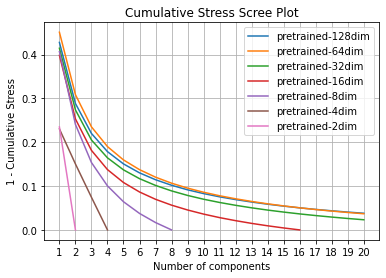

In [34]:
LIMIT = 20
plt.figure()
for model_name, stress_cdf in stress_cdfs.items():
    cdf = stress_cdf[:LIMIT]
    x_ticks = 1 + np.arange(len(cdf))
    plt.plot(x_ticks, stress_cdf[:LIMIT])
plt.xticks(1 + np.arange(LIMIT))
plt.xlabel("Number of components")
plt.ylabel("1 - Cumulative Stress")
plt.legend(list(models.keys()))
plt.title("Cumulative Stress Scree Plot")
plt.grid()
plt.show()